# Имопрт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
import re

# Чтение из файлов

In [11]:
brset_data = pd.read_csv("../a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.1/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.1/labels_brset.csv")
display(brset_data.sample(n=5))

,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,amd,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality
10618,img10619,5572,Canon CR,31.0,hypertension,NaN,NaN,2,1,No,...,0,0,0,0,0,0,0,1,0,Adequate
12371,img12372,6513,Canon CR,21.0,NaN,NaN,NaN,2,1,No,...,0,0,0,0,0,0,0,0,0,Inadequate
13548,img13549,7130,Canon CR,35.0,diabetes1,29,yes,1,2,yes,...,0,0,0,0,0,0,0,0,0,Adequate
6992,img06993,3679,Canon CR,53.0,0,NaN,NaN,2,1,No,...,0,0,0,0,0,0,0,1,0,Adequate
1303,img01304,681,Canon CR,59.0,diabetes,15,yes,1,2,yes,...,0,0,0,0,0,0,0,0,0,Inadequate


# Анализ данных

In [12]:
display(brset_data.isna().sum())
display(brset_data.info())

image_id                        0
patient_id                      0
camera                          0
patient_age                  5446
comorbidities                8237
diabetes_time_y             14356
insuline                    14552
patient_sex                     0
exam_eye                        0
diabetes                        0
nationality                     0
optic_disc                      0
vessels                         0
macula                          0
DR_SDRG                         0
DR_ICDR                         0
focus                           0
Illuminaton                     0
image_field                     0
artifacts                       0
diabetic_retinopathy            0
macular_edema                   0
scar                            0
nevus                           0
amd                             0
vascular_occlusion              0
hypertensive_retinopathy        0
drusens                         0
hemorrhage                      0
retinal_detach

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16266 entries, 0 to 16265
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_id                  16266 non-null  object 
 1   patient_id                16266 non-null  int64  
 2   camera                    16266 non-null  object 
 3   patient_age               10820 non-null  float64
 4   comorbidities             8029 non-null   object 
 5   diabetes_time_y           1910 non-null   object 
 6   insuline                  1714 non-null   object 
 7   patient_sex               16266 non-null  int64  
 8   exam_eye                  16266 non-null  int64  
 9   diabetes                  16266 non-null  object 
 10  nationality               16266 non-null  object 
 11  optic_disc                16266 non-null  object 
 12  vessels                   16266 non-null  int64  
 13  macula                    16266 non-null  int64  
 14  DR_SDR

None

# BRSET

Удаление столбцов почти со всеми пустыми значениями и строк, где patien age NaN и дубликатов

In [13]:
brset_data.drop(columns=['insuline', 'diabetes_time_y', 'comorbidities'], inplace=True)
brset_data.dropna(subset=['patient_age'], inplace=True)
display(brset_data.duplicated().sum())
brset_data.drop_duplicates(inplace=True)

0

Deleting rows with bad quality

In [15]:
bad_quality_indexes = brset_data[brset_data[['focus', 'Illuminaton', 'image_field', 'artifacts']].eq(2).any(axis=1)].index.to_list()
bad_quality_indexes.extend(brset_data[brset_data[['quality']].eq('Inadequate').any(axis=1)].index.to_list())
brset_data = brset_data.drop(index=bad_quality_indexes)

Распределение по возрасту

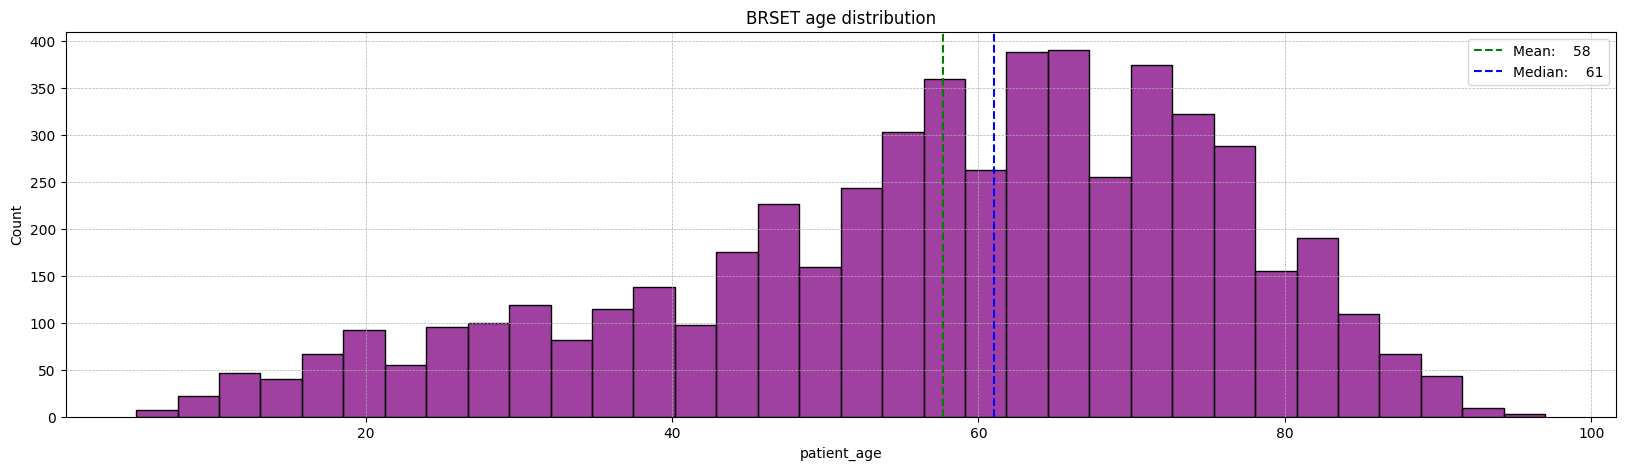

In [17]:
plt.figure(figsize=(20, 5))
brset_data_grouped_by_id = brset_data.groupby('patient_id').first().reset_index()
ax = sns.histplot(data = brset_data_grouped_by_id, x='patient_age', color='purple')

mean_age = np.nanmean(brset_data_grouped_by_id.patient_age)
median_age = np.nanmedian(brset_data_grouped_by_id.patient_age)
plt.axvline(x=mean_age, 
            linestyle = '--',
            label='Mean: {:5.0f}'.format(mean_age),
            color='green')
plt.axvline(x=median_age, 
            linestyle = '--',
            label='Median: {:5.0f}'.format(median_age),
            color='blue')
plt.grid(True, linestyle = '--', linewidth = 0.5)
plt.title("BRSET age distribution")
plt.legend(loc=0)
plt.show()

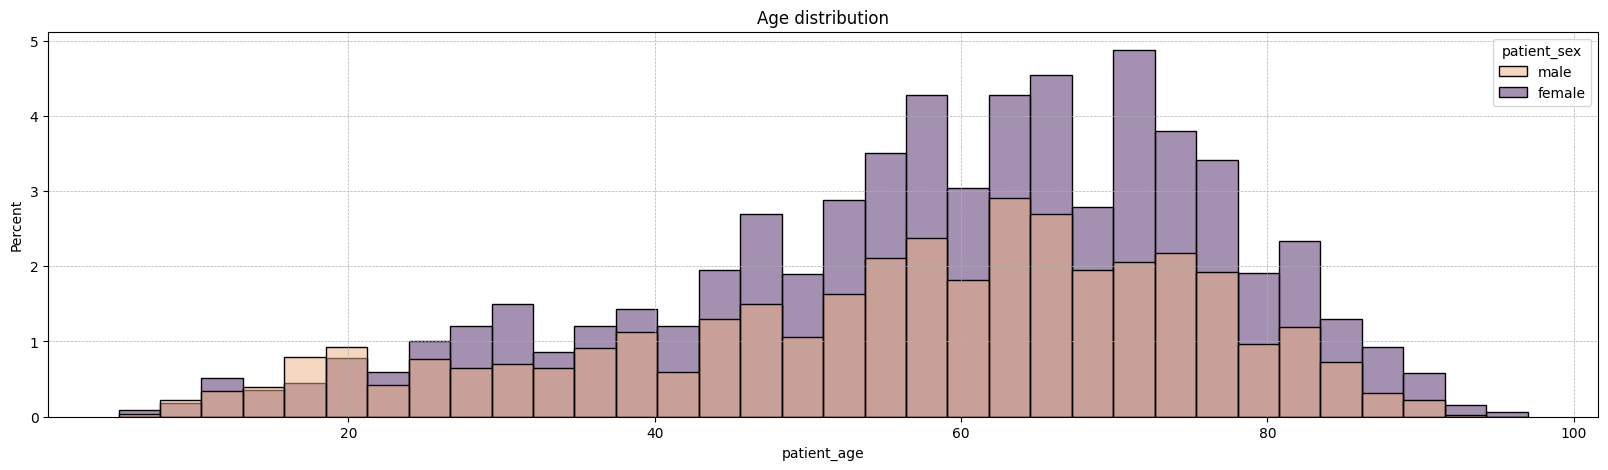

In [18]:
plt.figure(figsize=(20, 5))
labels = ['male', 'female']
brset_data_grouped_by_id = brset_data.groupby('patient_id').first().reset_index()
ax = sns.histplot(data = brset_data_grouped_by_id, x='patient_age', stat='percent', hue='patient_sex', palette='flare')
plt.grid(True, linestyle = '--', linewidth = 0.5)
plt.title("Age distribution")
for text, label in zip(ax.get_legend().texts, labels):
    text.set_text(label)

plt.show()

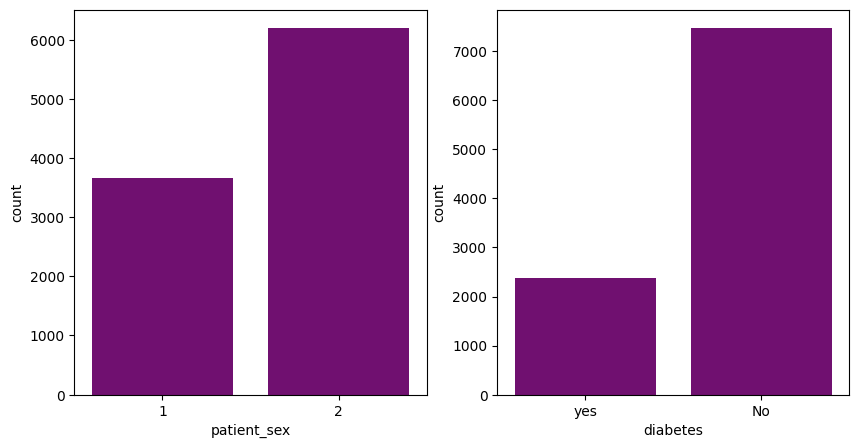

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

columns = ['patient_sex', 'diabetes']
for indx, column in enumerate(columns):
    sns.countplot(data=brset_data, x=column, color='purple', ax=axes[indx])

plt.show()

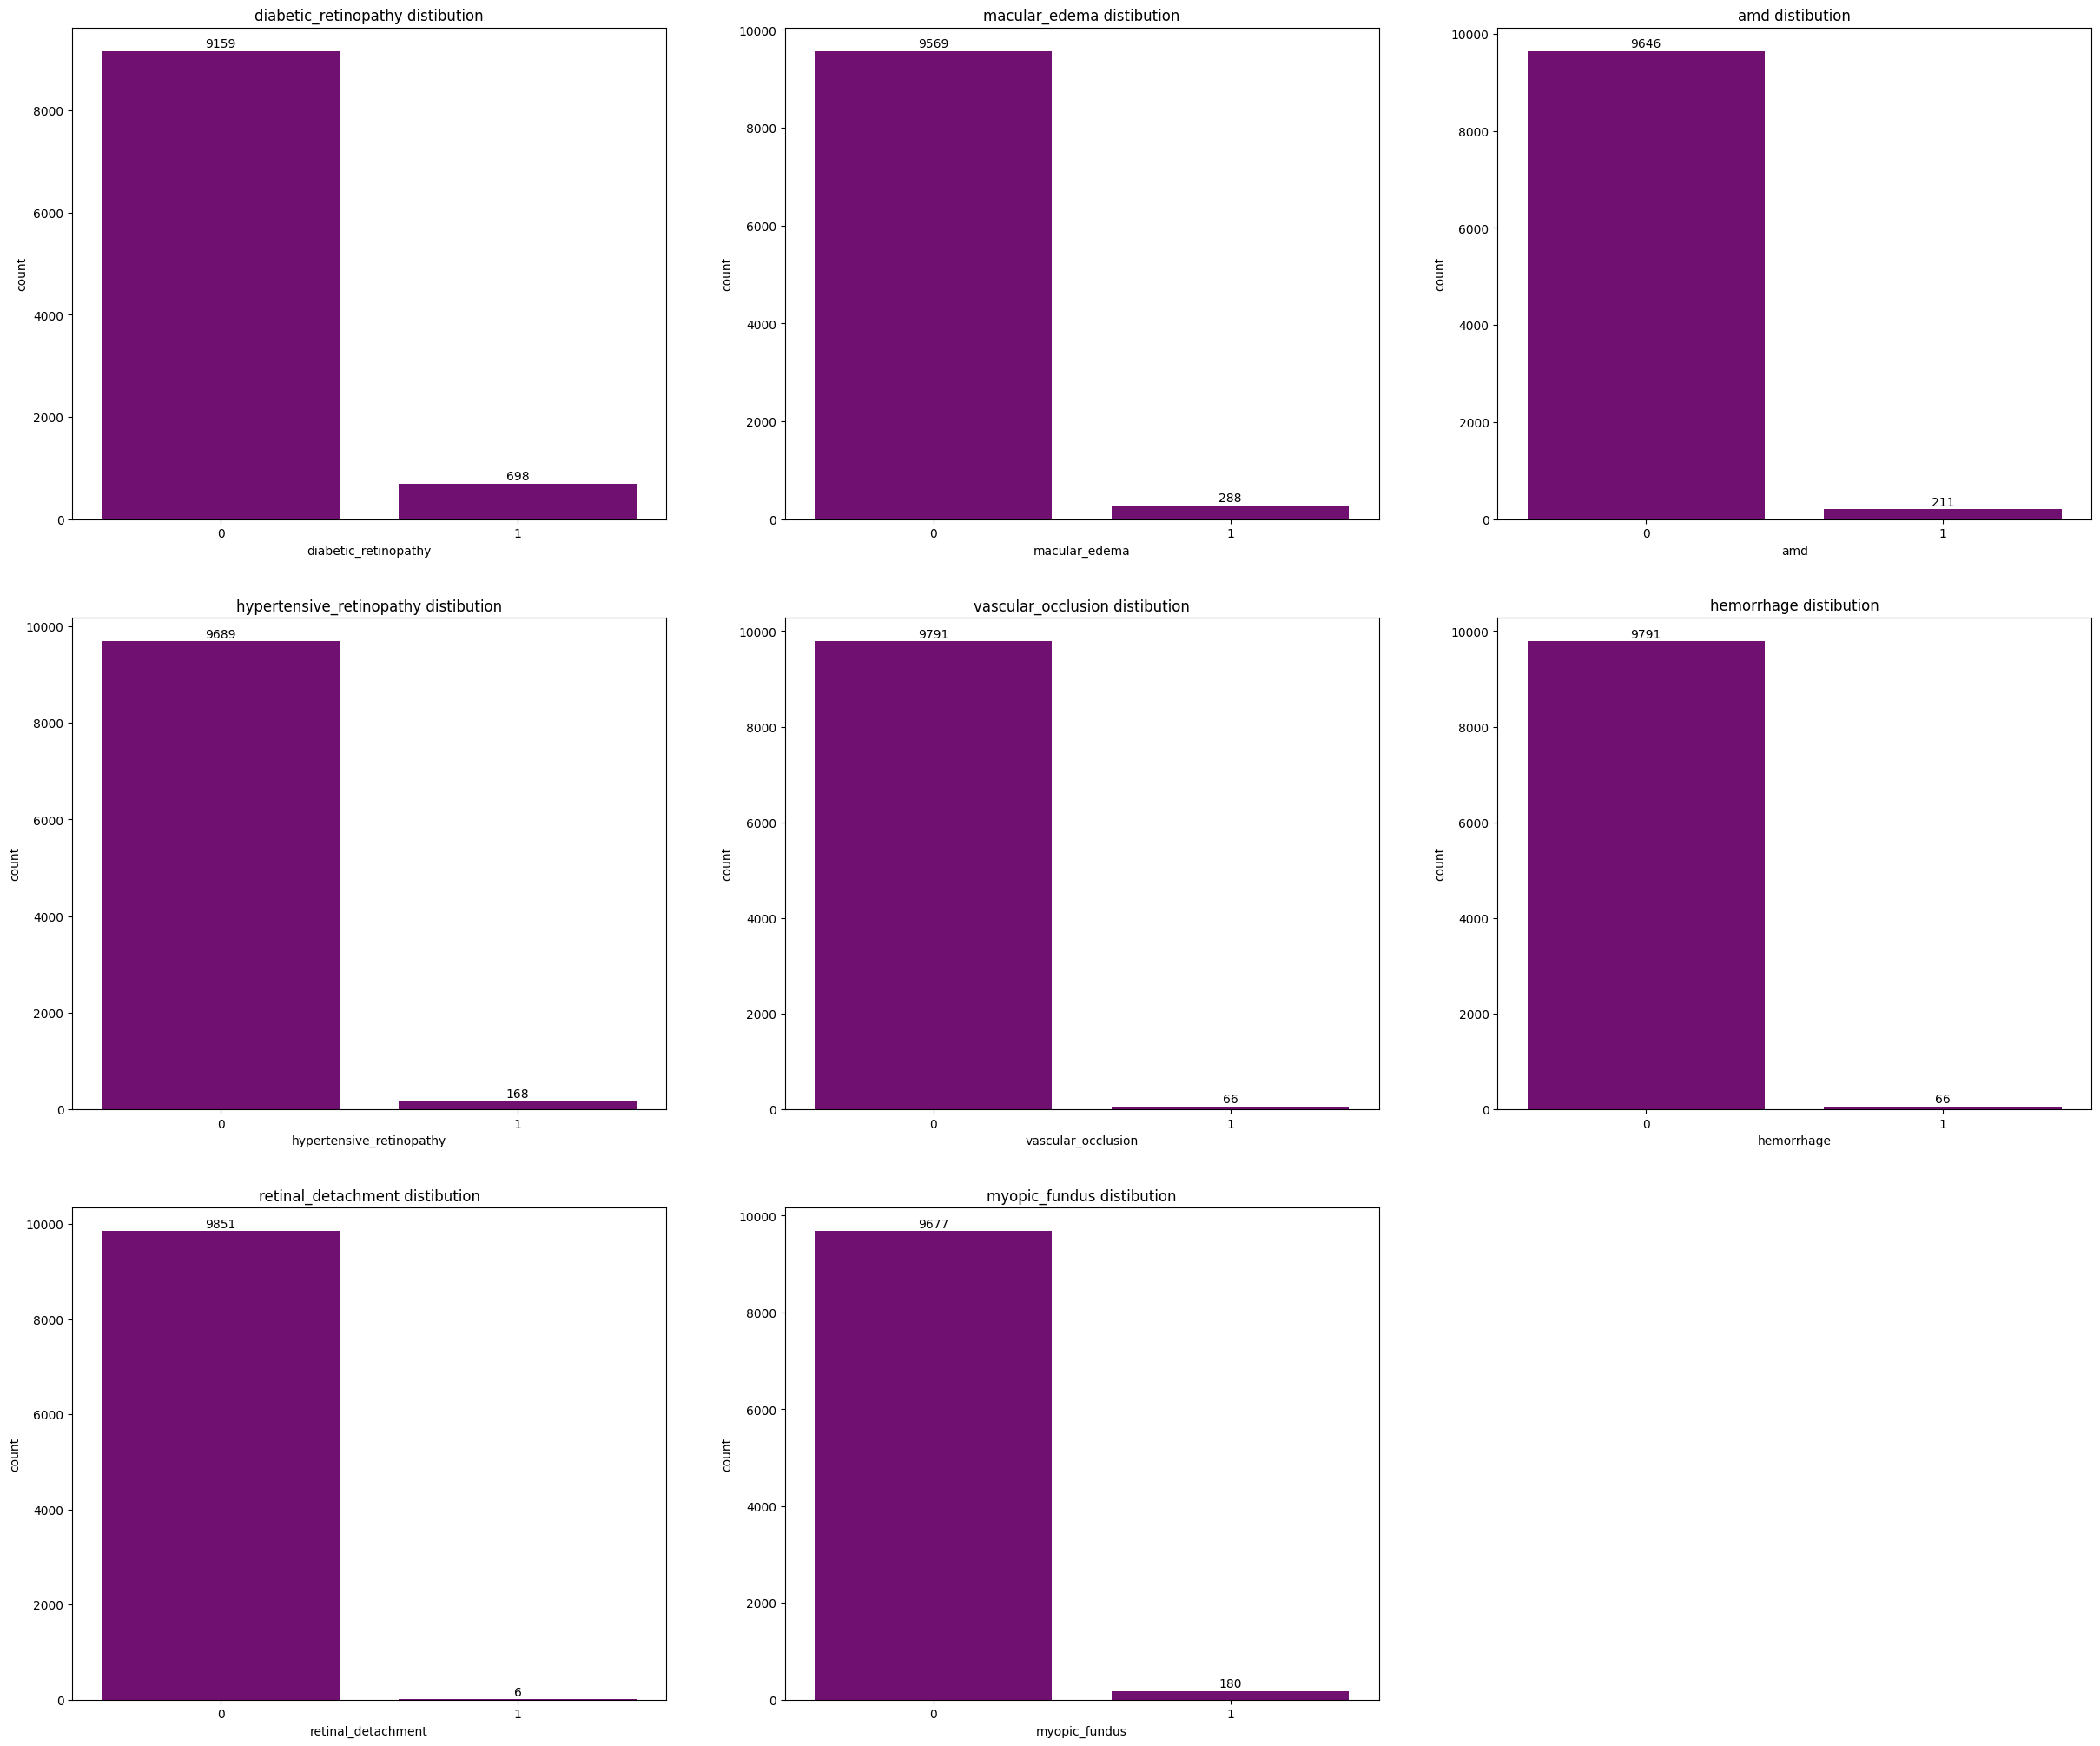

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(30, 25))
columns_for_hist = ['diabetic_retinopathy', 'macular_edema', 'amd', 'hypertensive_retinopathy', 'vascular_occlusion',
                    'hemorrhage', 'retinal_detachment', 'myopic_fundus']
for indx, column in enumerate(columns_for_hist):
    sns.countplot(data=brset_data, x=column, ax=axes[indx // 3][indx % 3], color='purple') 
    axes[indx // 3][indx % 3].set_title(f'{column} distibution')
    for p in axes[indx // 3][indx % 3].patches:
        axes[indx // 3][indx % 3].annotate(f"{p.get_height():.0f}\n", (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha="center", va="center", color='black')
fig.delaxes(axes[-1][-1])
plt.show()
    

In [22]:
brset_data['diabetes'].value_counts()

diabetes
No     7478
yes    2379
Name: count, dtype: int64

In [23]:
brset_data['diabetes'] = pd.Series(np.where(brset_data.diabetes.values == 'yes', 1, 0),
          brset_data.index)

In [24]:
brset_data['diabetes'].value_counts()

diabetes
0    7478
1    2379
Name: count, dtype: int64

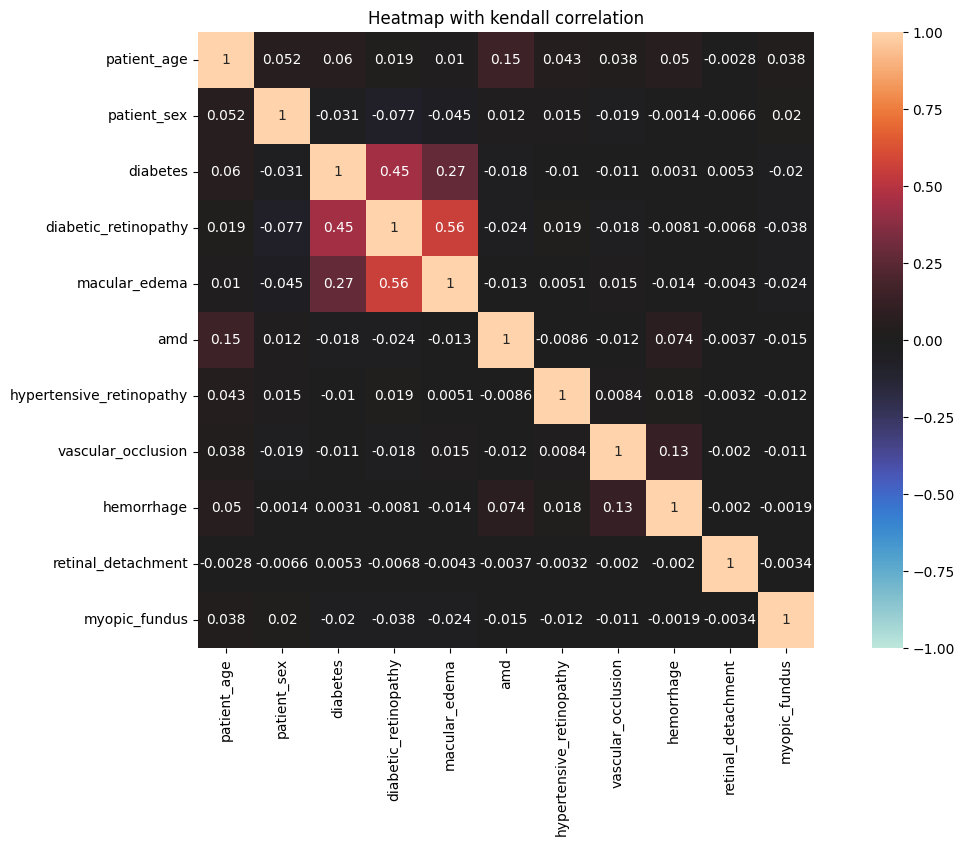

In [28]:
plt.figure(figsize=(15, 8))

sns.heatmap(brset_data[['patient_age', 'patient_sex', 'diabetes',
                        'diabetic_retinopathy', 'macular_edema', 'amd', 'hypertensive_retinopathy', 'vascular_occlusion',
                        'hemorrhage', 'retinal_detachment', 'myopic_fundus']].corr(method='kendall'), 
            annot = True, fmt='.2g', square=True, vmin=-1, vmax=1, center= 0)
plt.title('Heatmap with kendall correlation')
plt.show()

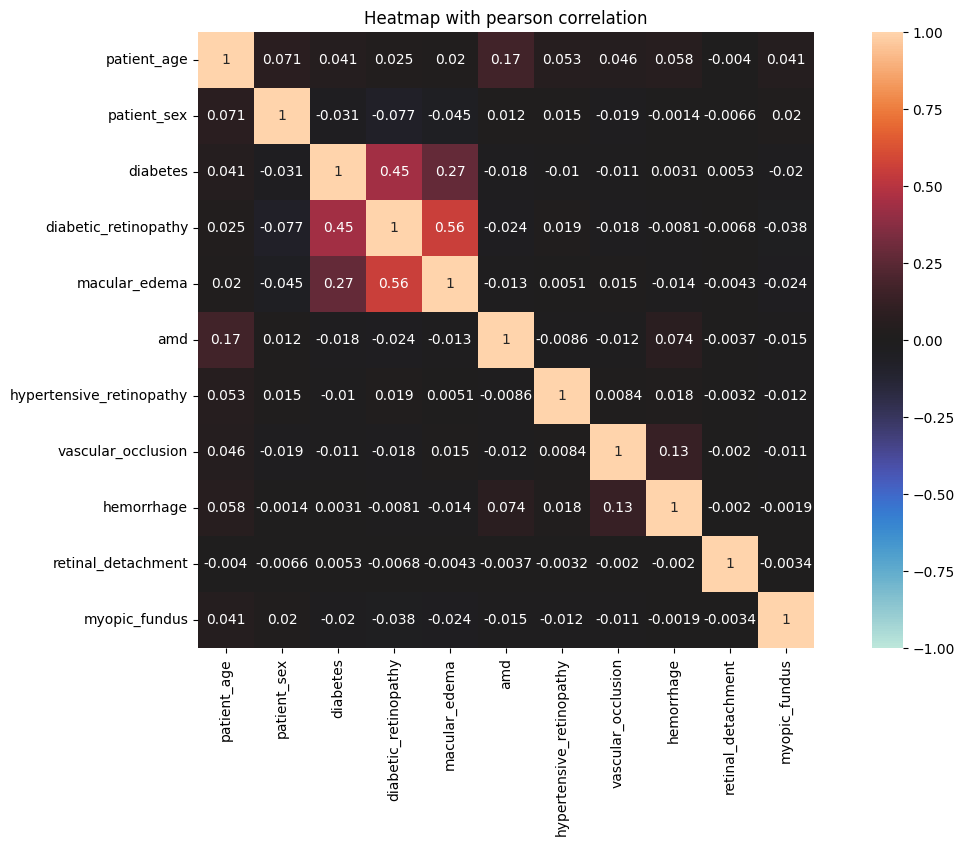

In [29]:
plt.figure(figsize=(15, 8))

sns.heatmap(brset_data[['patient_age', 'patient_sex', 'diabetes',
                        'diabetic_retinopathy', 'macular_edema', 'amd', 'hypertensive_retinopathy', 'vascular_occlusion',
                        'hemorrhage', 'retinal_detachment', 'myopic_fundus']].corr(method='pearson'), 
            annot = True, fmt='.2g', square=True, vmin=-1, vmax=1, center= 0)
plt.title('Heatmap with pearson correlation')
plt.show()

# Распределение возраста по патологиям

In [30]:
def plot_age_by_pathology(dataset, pathology):
    plt.figure(figsize=(10, 5))
    dataset_grouped_by_id = dataset.groupby('patient_id').first().reset_index()
    pathology_only_dataset = dataset_grouped_by_id[dataset_grouped_by_id[pathology] == 1]
    sns.histplot(data = pathology_only_dataset, x='patient_age', color='purple')
    plt.grid(True, linestyle = '--', linewidth = 0.5)
    mean_age = np.nanmean(pathology_only_dataset.patient_age)
    median_age = np.nanmedian(pathology_only_dataset.patient_age)
    plt.axvline(x=mean_age, 
                linestyle = '--',
                label='Mean: {:5.0f}'.format(mean_age),
                color='green')
    plt.axvline(x=median_age, 
                linestyle = '--',
                label='Median: {:5.0f}'.format(median_age),
                color='blue')
    plt.title(f'Age distribution in case of {pathology}')
    plt.legend(loc=0)
    plt.show()

def plot_sex_by_pathology(dataset, pathology):
    legend_labels = {1: 'male', 2: 'female'}

    pathology_data = (
        dataset.groupby('patient_sex')[pathology]
        .mean()
        .reset_index()
        .replace({'patient_sex': legend_labels})
    )

    plt.figure(figsize=(5, 5))
    sns.barplot(data=pathology_data, hue='patient_sex', y=pathology, palette='flare')
    plt.title(f'Proportion of Patients with {pathology} by Sex')
    plt.xlabel("Patient Sex")
    plt.ylabel(f'Proportion')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

Macular edema

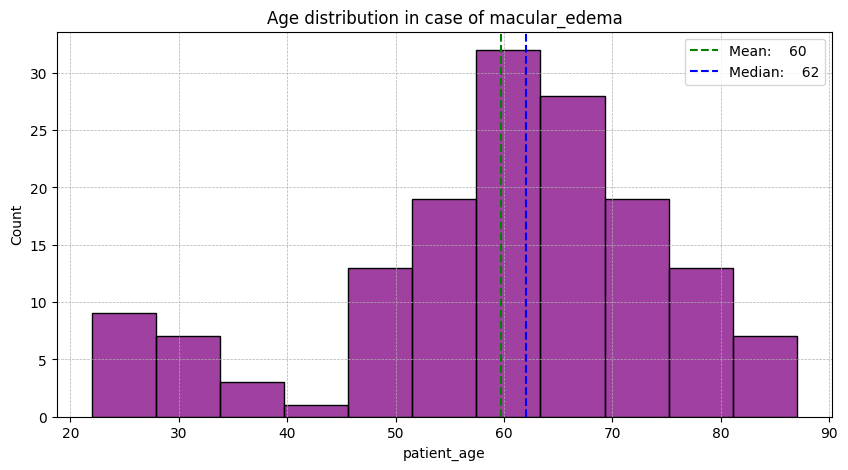

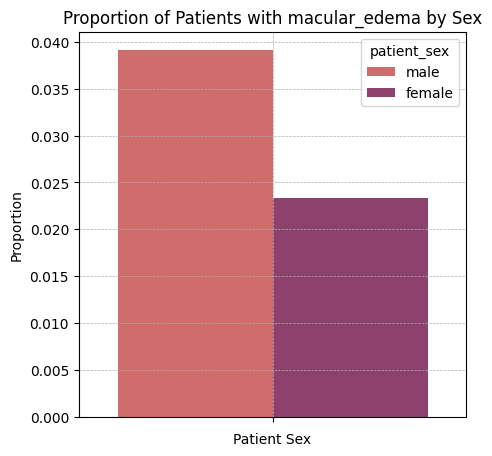

In [31]:
plot_age_by_pathology(brset_data, 'macular_edema')
plot_sex_by_pathology(brset_data, 'macular_edema')

Diabetic Retinopathy

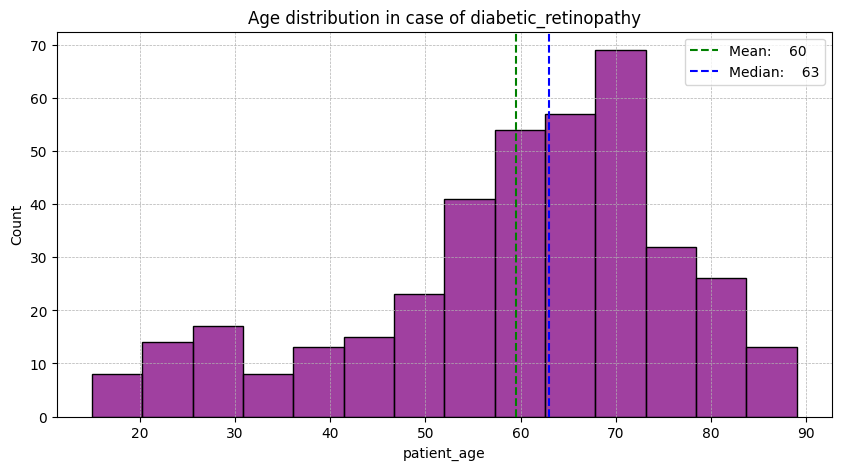

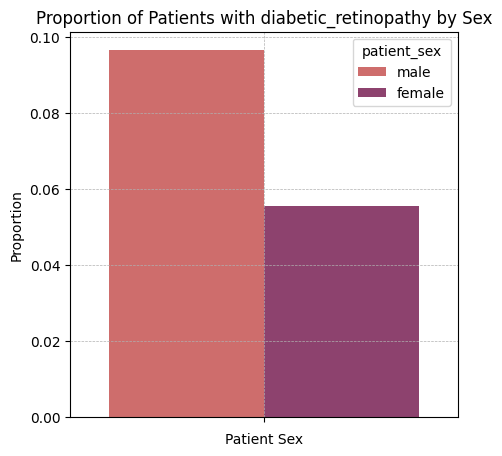

In [32]:
plot_age_by_pathology(brset_data, 'diabetic_retinopathy')
plot_sex_by_pathology(brset_data, 'diabetic_retinopathy')

Age macular degeneration

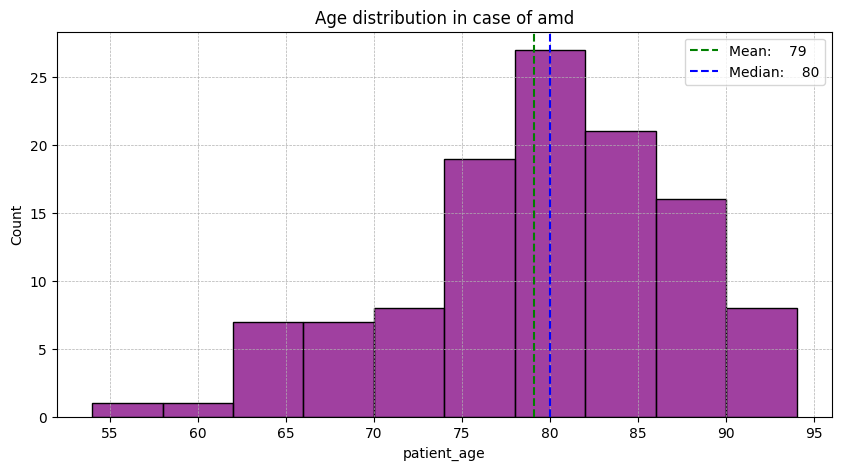

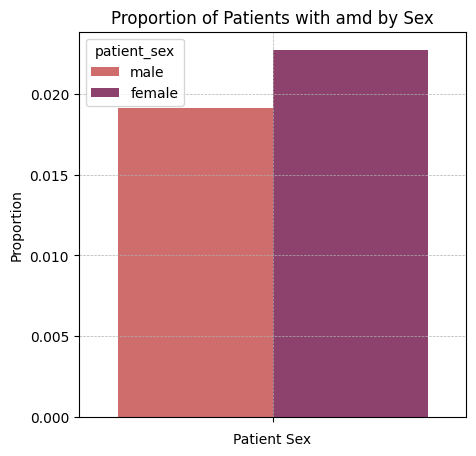

In [33]:
plot_age_by_pathology(brset_data, 'amd')
plot_sex_by_pathology(brset_data, 'amd')

Hypertensive retinopathy

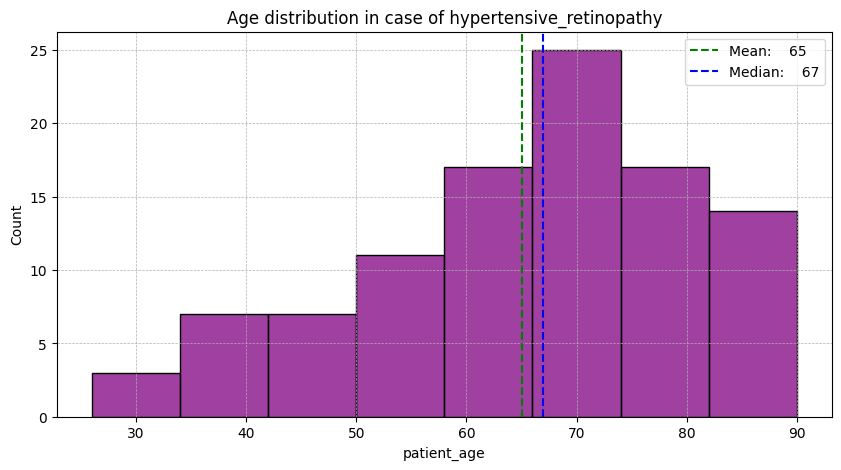

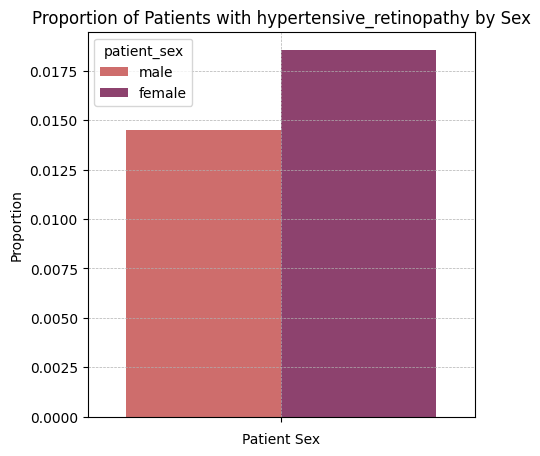

In [34]:
plot_age_by_pathology(brset_data, 'hypertensive_retinopathy')
plot_sex_by_pathology(brset_data, 'hypertensive_retinopathy')

vascular occlusion

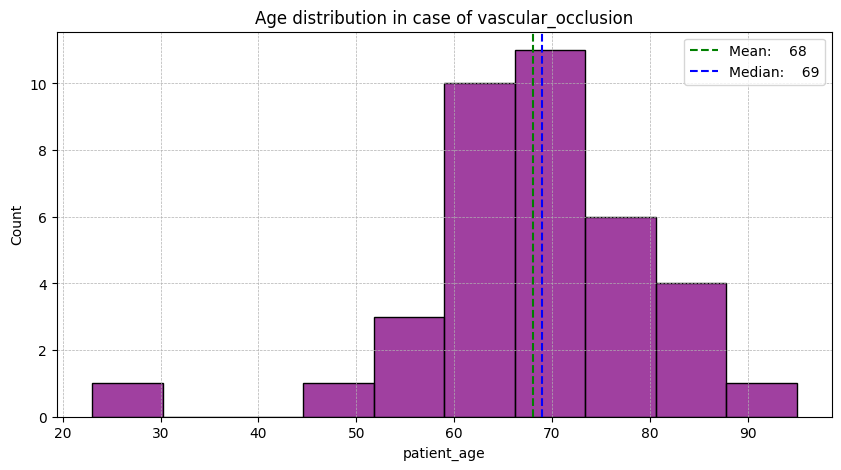

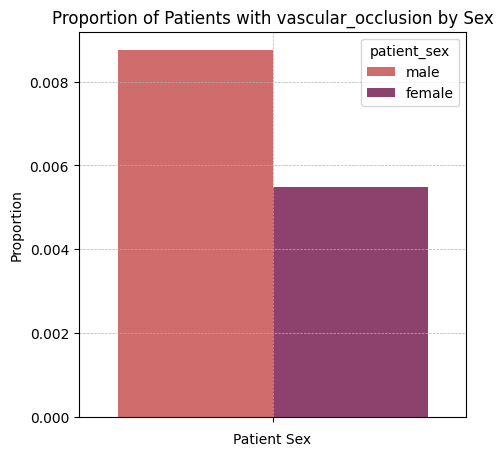

In [35]:
plot_age_by_pathology(brset_data, 'vascular_occlusion')
plot_sex_by_pathology(brset_data, 'vascular_occlusion')

Hemorrhage

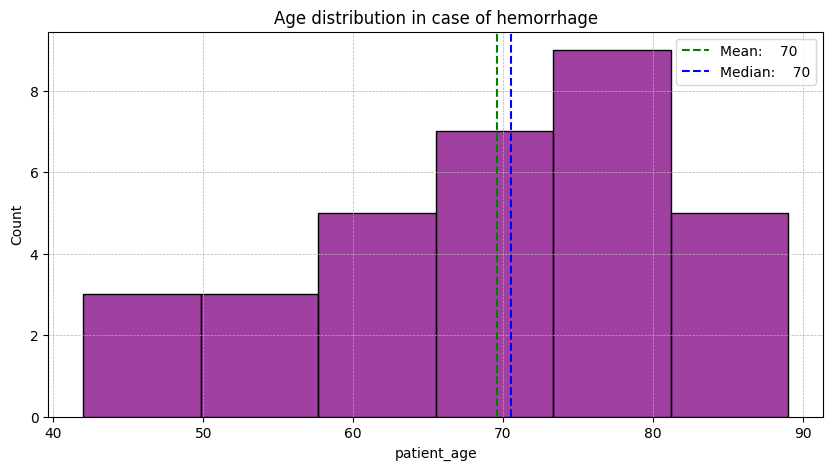

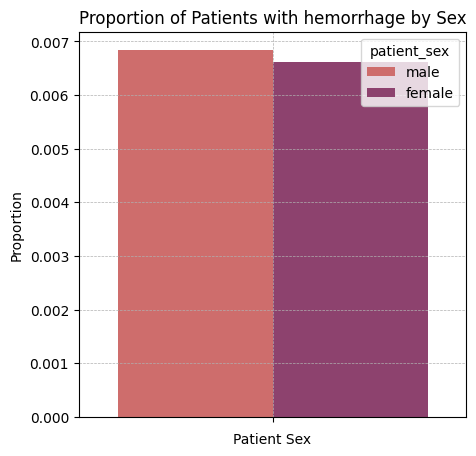

In [36]:
plot_age_by_pathology(brset_data, 'hemorrhage')
plot_sex_by_pathology(brset_data, 'hemorrhage')

Retinal detachment

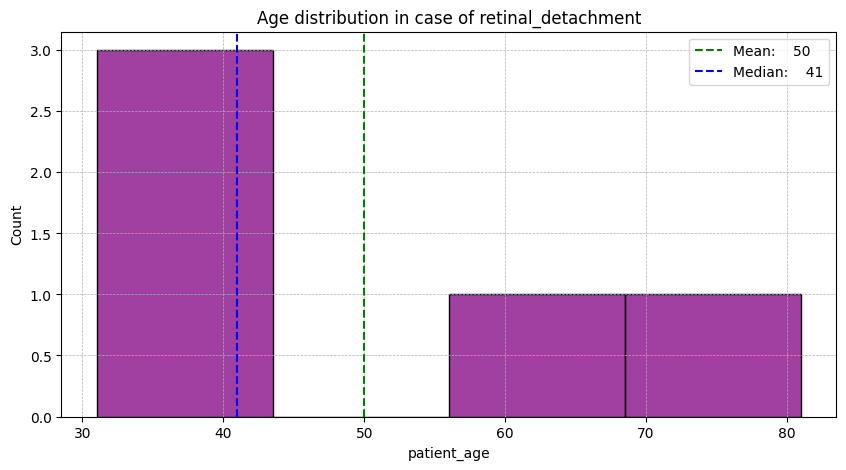

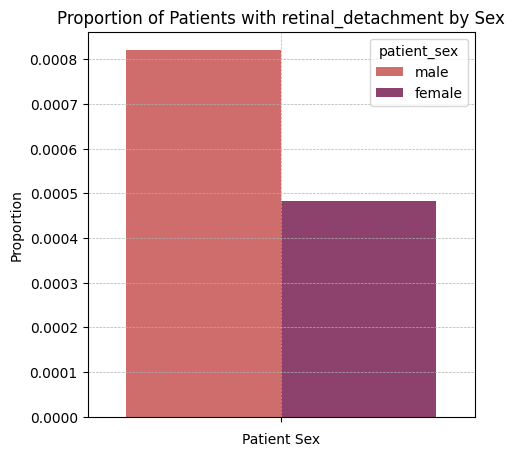

In [37]:
plot_age_by_pathology(brset_data, 'retinal_detachment')
plot_sex_by_pathology(brset_data, 'retinal_detachment')

Myopic fundus

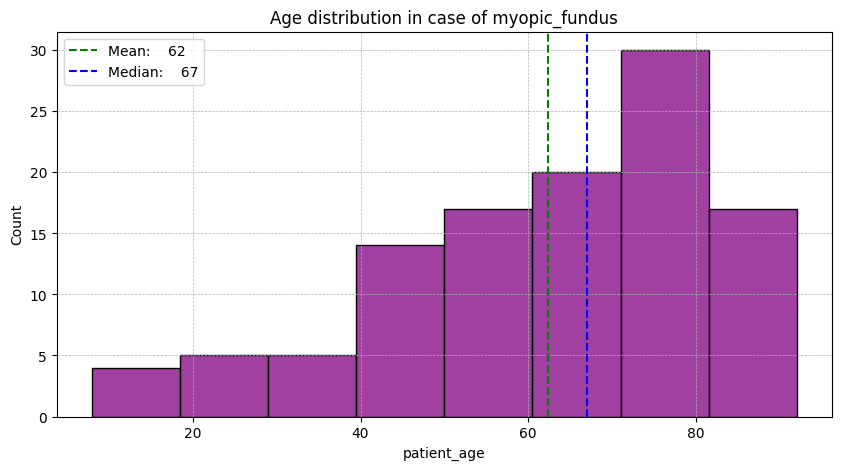

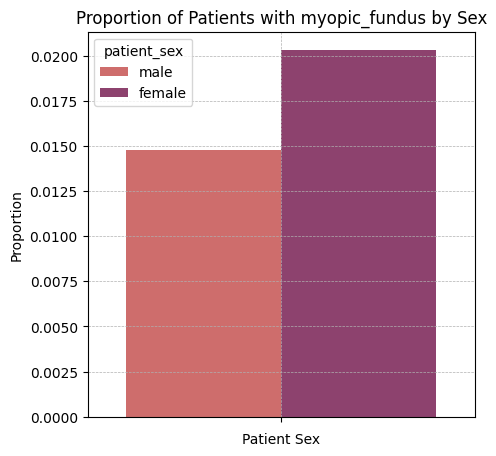

In [38]:
plot_age_by_pathology(brset_data, 'myopic_fundus')
plot_sex_by_pathology(brset_data, 'myopic_fundus')

# ODIR


# Обработка набора данных

In [44]:
odir_data_full_df = pd.read_csv("../ODIR-5K/ODIR-5K/full_df.csv")
odir_data = pd.read_csv("../ODIR-5K/ODIR-5K/data.csv")

In [45]:
odir_data_full_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


classification based in diagnostic keywords

In [46]:
import re

def create_new_row(id, age, sex, eye_fundus, eye, disease_dict):
    new_row = {
        "patient_id": id,
        "patient_age": age, 
        "patient_sex": sex,
        "fundus_image": eye_fundus,
        "exam_eye": 2 if eye == "left" else 1,
        "normal_eye": disease_dict["n"],
        "diabetic_retinopathy": disease_dict["d"],
        "glaucoma": disease_dict["g"],
        "cataract": disease_dict["c"],
        "amd": disease_dict["a"],
        "hypertension": disease_dict["h"],
        "myopia": disease_dict["m"],
        "other": disease_dict["o"]
    }
    return new_row


rows = []

for _, row in odir_data.iterrows():
    for eye, column in [("left", "Left-Diagnostic Keywords"), ("right", "Right-Diagnostic Keywords")]:
        disease_dict = {"n": 0,
                        "d": 0,
                        "g": 0,
                        "c": 0,
                        "a": 0,
                        "h": 0,
                        "m": 0,
                        "o": 0}
        number_of_diagnosed_diseases = len(row[column].split(','))
        number_of_found_diseases = 0
        if re.search(r'normal fundus', row[column]):
            disease_dict["n"] = 1
            number_of_found_diseases += 1
        if re.search(r'(proliferative retinopathy|diabetic retinopathy)', row[column]):
            disease_dict["d"] = 1
            number_of_found_diseases += 1
        if re.search(r'glaucoma', row[column]):
            disease_dict["g"] = 1
            number_of_found_diseases += 1
        if re.search(r'cataract', row[column]):
            disease_dict["c"] = 1
            number_of_found_diseases += 1
        if re.search(r'age-related macular degeneration', row[column]):
            disease_dict["a"] = 1
            number_of_found_diseases += 1
        if re.search(r'hypertensive retinopathy', row[column]):
            disease_dict["h"] = 1
            number_of_found_diseases += 1
        if re.search(r'myopia', row[column]):
            disease_dict["m"] = 1
            number_of_found_diseases += 1
        if number_of_found_diseases < number_of_diagnosed_diseases:
            disease_dict["o"] = 1
        fundus_file_name = 'Left-Fundus' if eye == "left" else 'Right-Fundus'
        created_row = create_new_row(row['ID'], row['Patient Age'], row['Patient Sex'], row[fundus_file_name], eye, disease_dict)
        rows.append(pd.Series(created_row))

new_odir_dataset = pd.DataFrame(rows)
new_odir_dataset.reset_index(inplace=True, drop=True)
display(new_odir_dataset)

,patient_id,patient_age,patient_sex,fundus_image,exam_eye,normal_eye,diabetic_retinopathy,glaucoma,cataract,amd,hypertension,myopia,other
0,0,69,Female,0_left.jpg,2,0,0,0,1,0,0,0,0
1,0,69,Female,0_right.jpg,1,1,0,0,0,0,0,0,0
2,1,57,Male,1_left.jpg,2,1,0,0,0,0,0,0,0
3,1,57,Male,1_right.jpg,1,1,0,0,0,0,0,0,0
4,2,42,Male,2_left.jpg,2,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,4689,54,Male,4689_right.jpg,1,1,0,0,0,0,0,0,0
6996,4690,57,Male,4690_left.jpg,2,0,1,0,0,0,0,0,0
6997,4690,57,Male,4690_right.jpg,1,0,1,0,0,0,0,0,0
6998,4784,58,Male,4784_left.jpg,2,0,0,0,0,1,1,0,0


In [47]:
new_odir_dataset['patient_sex'] = pd.Series(np.where(new_odir_dataset.patient_sex.values == 'Male', 1, 2),
          new_odir_dataset.index)

# Построение графиков

Распределение по возрасту

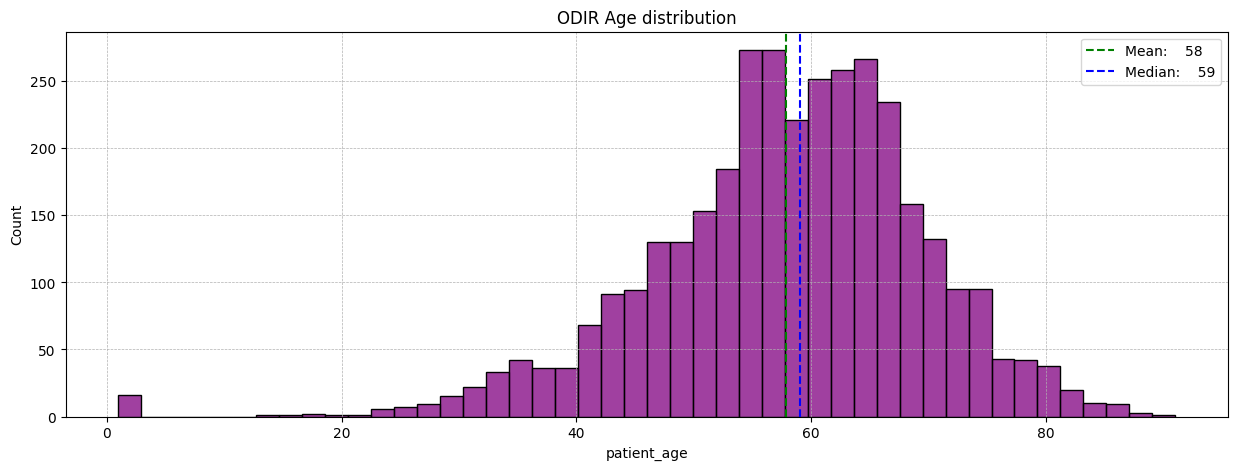

In [48]:
plt.figure(figsize=(15, 5))
new_odir_dataset_grouped_by_id = new_odir_dataset.groupby('patient_id').first().reset_index()
ax = sns.histplot(data = new_odir_dataset_grouped_by_id, x='patient_age', color='purple')

mean_age = np.nanmean(new_odir_dataset_grouped_by_id['patient_age'])
median_age = np.nanmedian(new_odir_dataset_grouped_by_id['patient_age'])
plt.axvline(x=mean_age, 
            linestyle = '--',
            label='Mean: {:5.0f}'.format(mean_age),
            color='green')
plt.axvline(x=median_age, 
            linestyle = '--',
            label='Median: {:5.0f}'.format(median_age),
            color='blue')
plt.grid(True, linestyle = '--', linewidth = 0.5)
plt.title("ODIR Age distribution")
plt.legend(loc=0)
plt.show()

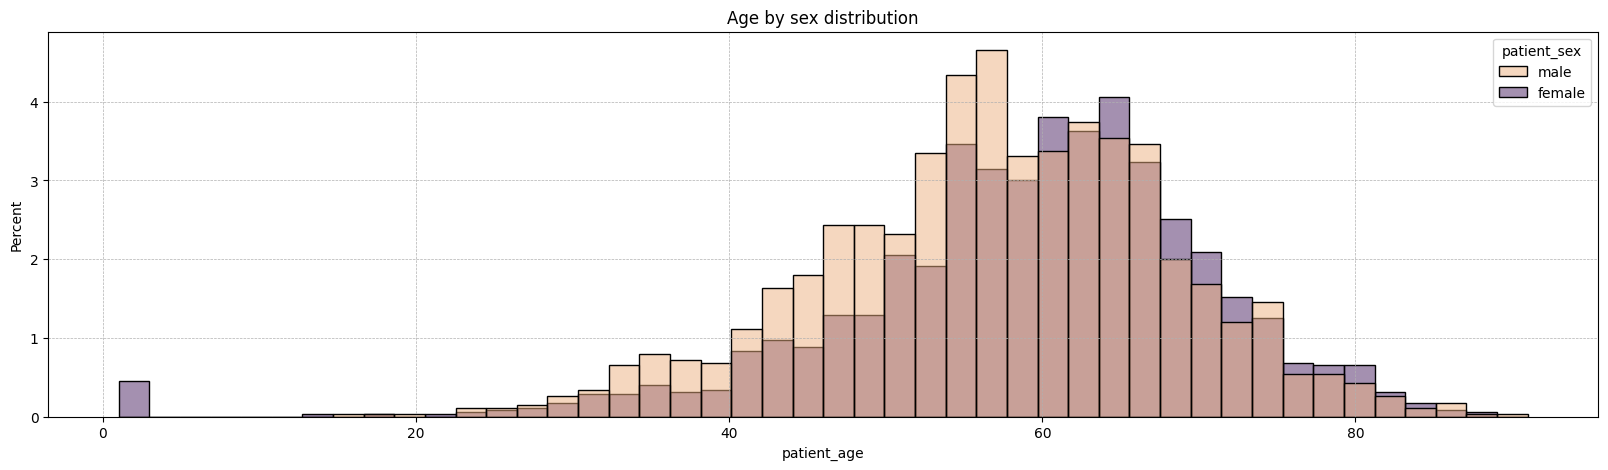

In [49]:
plt.figure(figsize=(20, 5))
labels = ['male', 'female']
ax = sns.histplot(data = new_odir_dataset_grouped_by_id, x='patient_age', stat='percent', hue='patient_sex', palette='flare')
plt.grid(True, linestyle = '--', linewidth = 0.5)
plt.title("Age by sex distribution")
for text, label in zip(ax.get_legend().texts, labels):
    text.set_text(label)

plt.show()

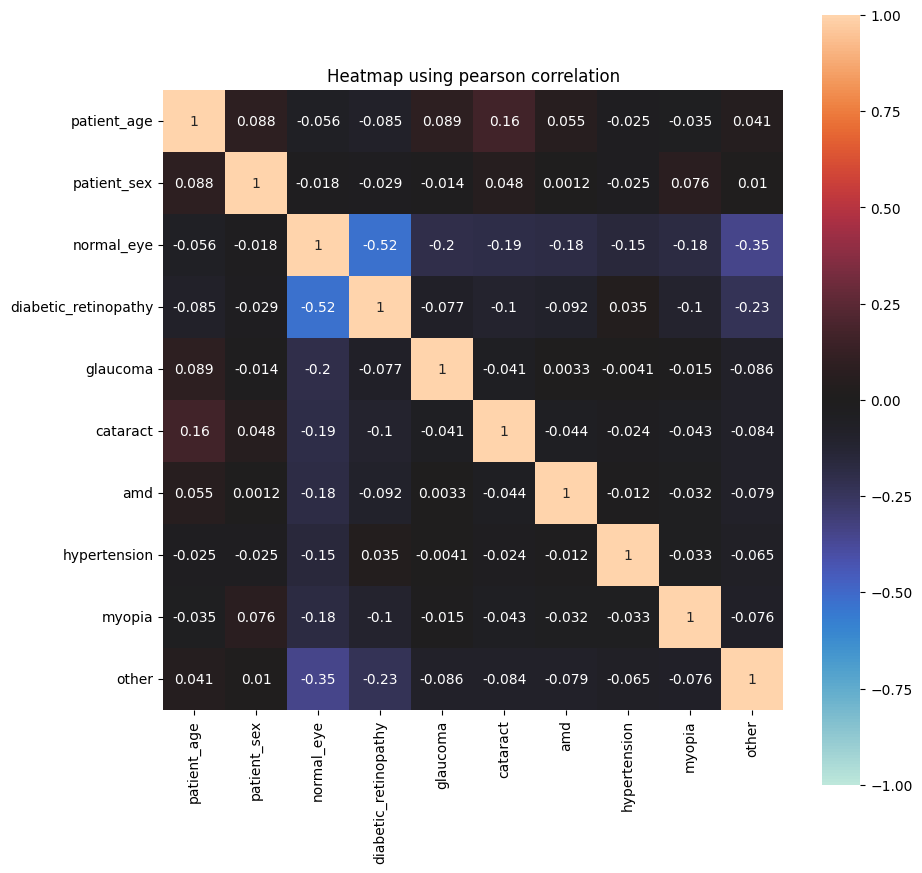

In [53]:
plt.figure(figsize=(10,10))
sns.heatmap(data=new_odir_dataset[['patient_age', 'patient_sex', 'normal_eye', 'diabetic_retinopathy', 'glaucoma', 'cataract', 'amd', 'hypertension', 'myopia', 'other']].corr(method='pearson'), 
            annot = True, fmt='.2g', square=True, vmin=-1, vmax=1, center= 0)
plt.title('Heatmap using pearson correlation')
plt.show()

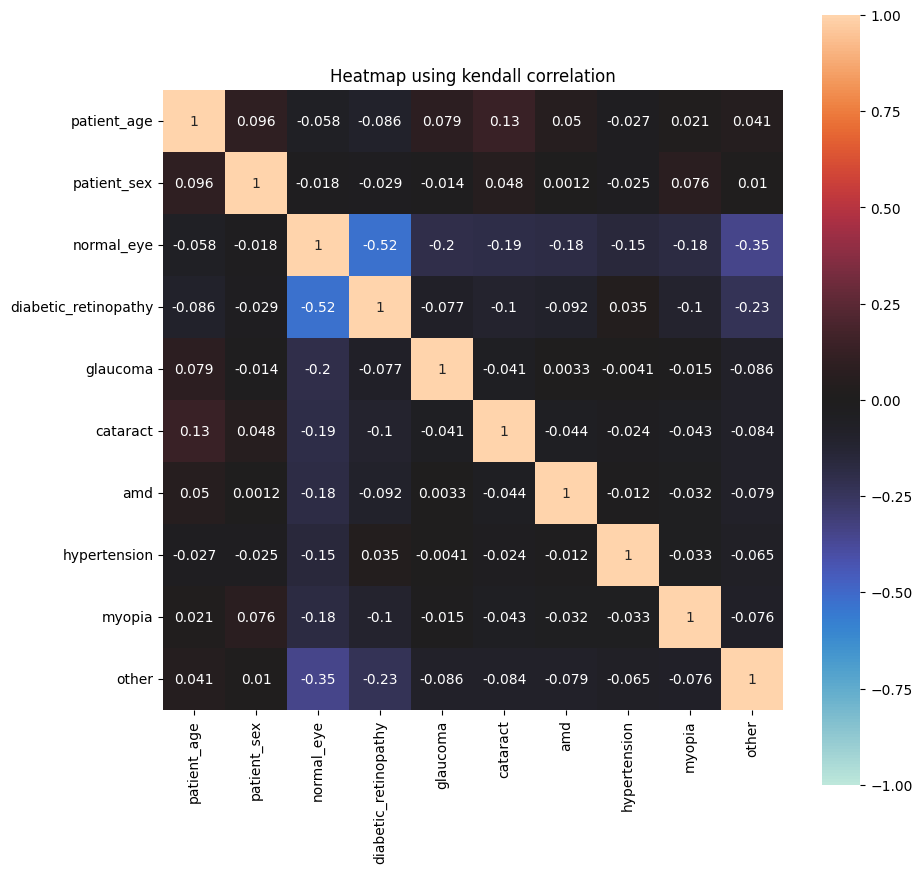

In [51]:
plt.figure(figsize=(10,10))
sns.heatmap(data=new_odir_dataset[['patient_age', 'patient_sex', 'normal_eye', 'diabetic_retinopathy', 'glaucoma', 'cataract', 'amd', 'hypertension', 'myopia', 'other']].corr(method='kendall'), 
            annot = True, fmt='.2g', square=True, vmin=-1, vmax=1, center= 0)
plt.title('Heatmap using kendall correlation')
plt.show()

# Распределение патологий по полу и возрасту

Диабетическая ретинопатия

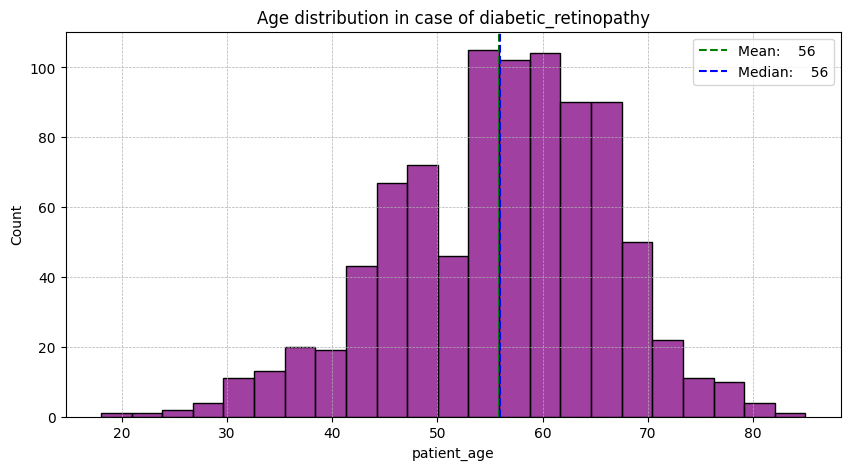

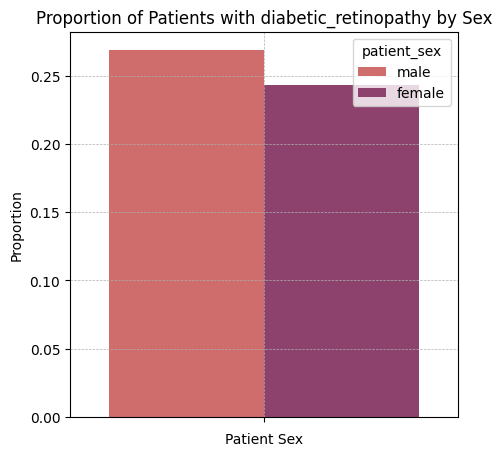

In [54]:
plot_age_by_pathology(new_odir_dataset, 'diabetic_retinopathy')
plot_sex_by_pathology(new_odir_dataset, 'diabetic_retinopathy')

Глаукома

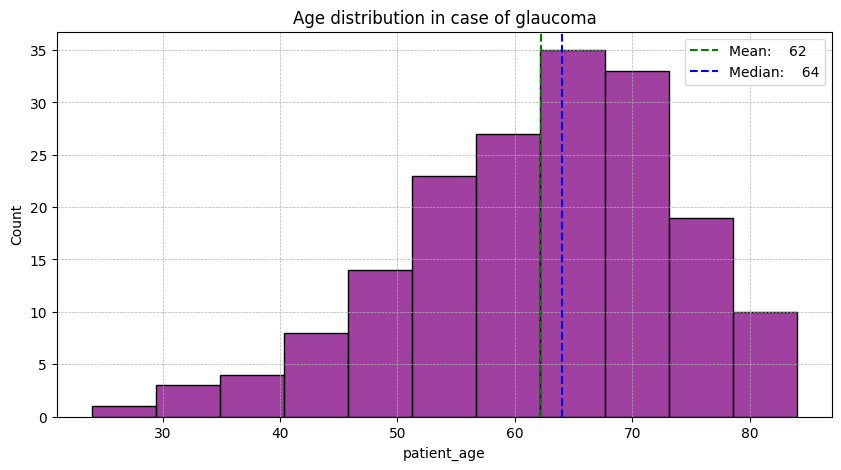

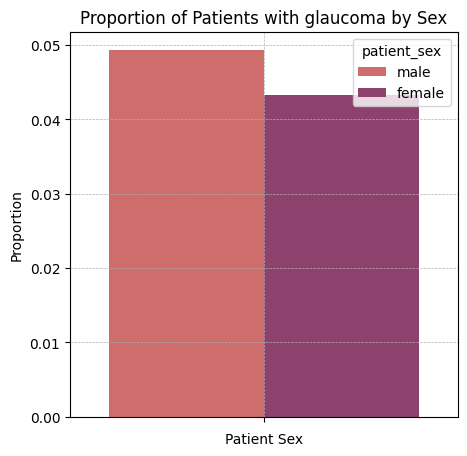

In [55]:
plot_age_by_pathology(new_odir_dataset, 'glaucoma')
plot_sex_by_pathology(new_odir_dataset, 'glaucoma')

Катаракта

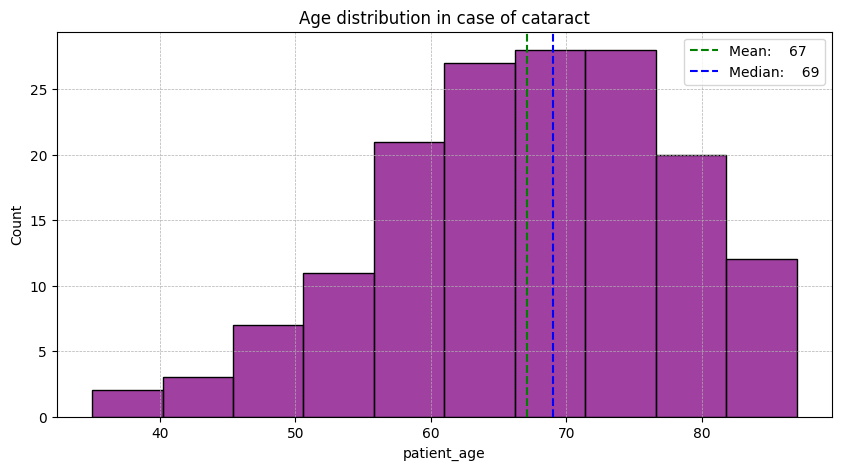

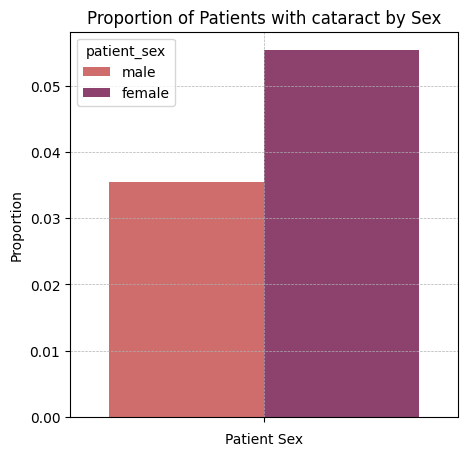

In [56]:
plot_age_by_pathology(new_odir_dataset, 'cataract')
plot_sex_by_pathology(new_odir_dataset, 'cataract')

Возрастная макулярная дегенерация

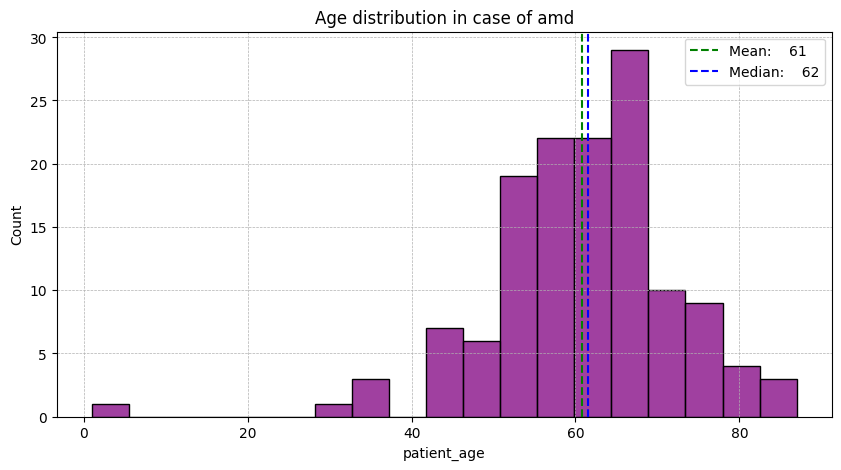

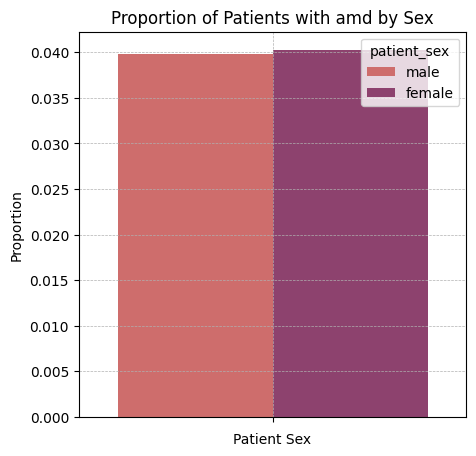

In [57]:
plot_age_by_pathology(new_odir_dataset, 'amd')
plot_sex_by_pathology(new_odir_dataset, 'amd')

Глазная гипертензия

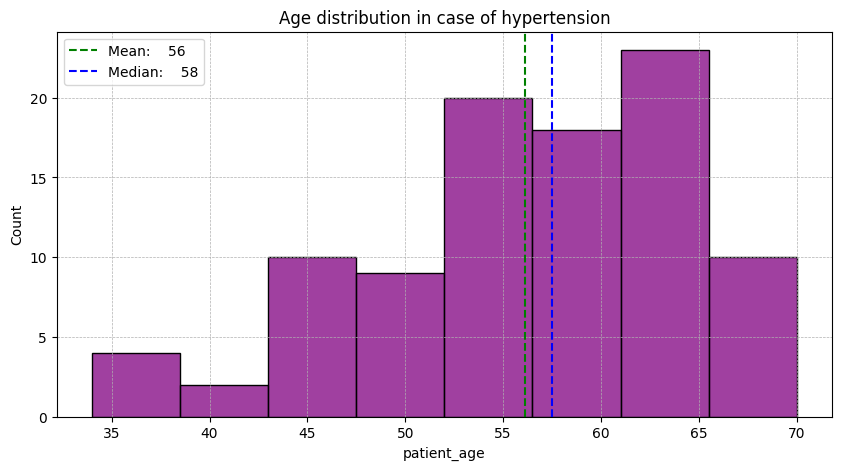

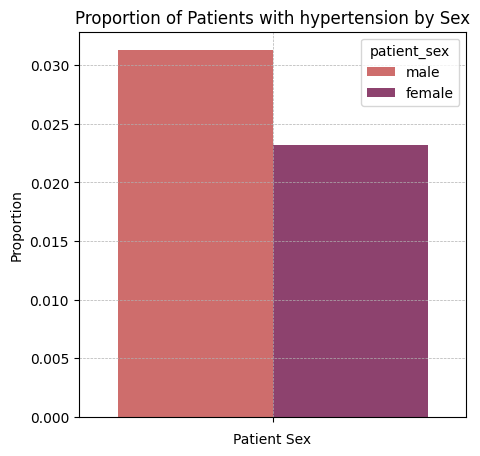

In [34]:
plot_age_by_pathology(new_odir_dataset, 'hypertension')
plot_sex_by_pathology(new_odir_dataset, 'hypertension')

Миопия

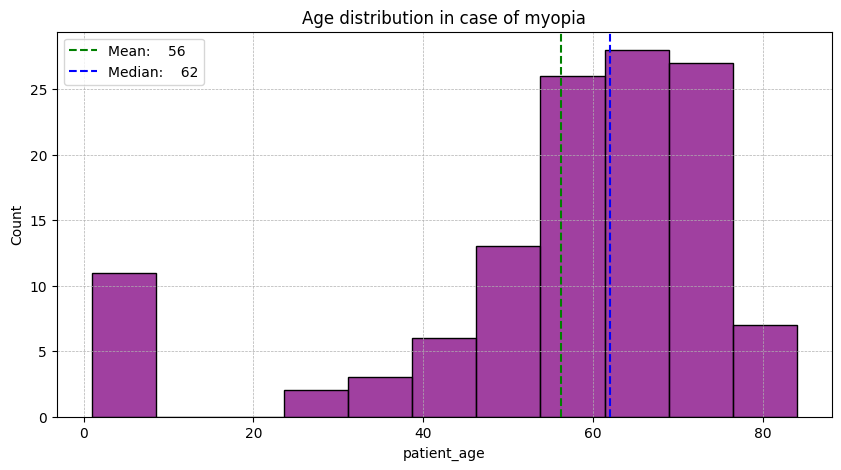

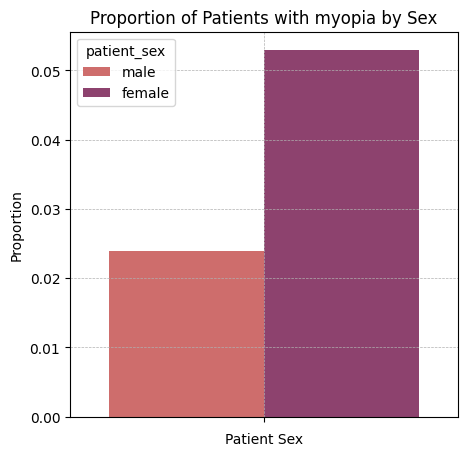

In [58]:
plot_age_by_pathology(new_odir_dataset, 'myopia')
plot_sex_by_pathology(new_odir_dataset, 'myopia')

Другие заболевания

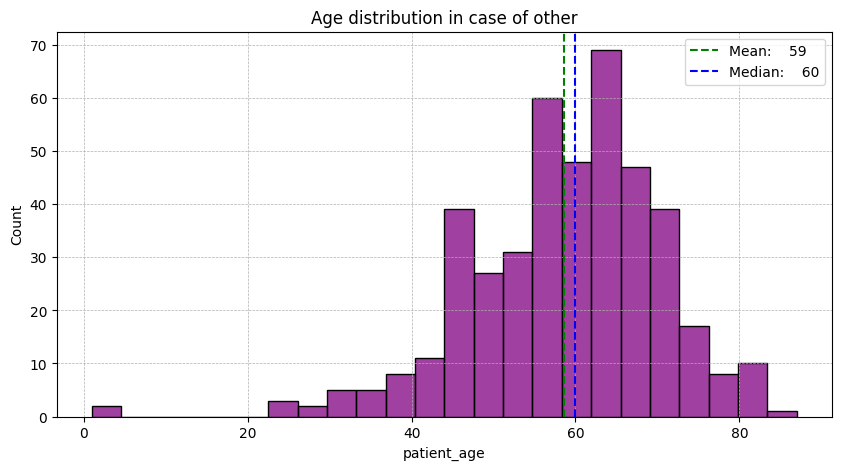

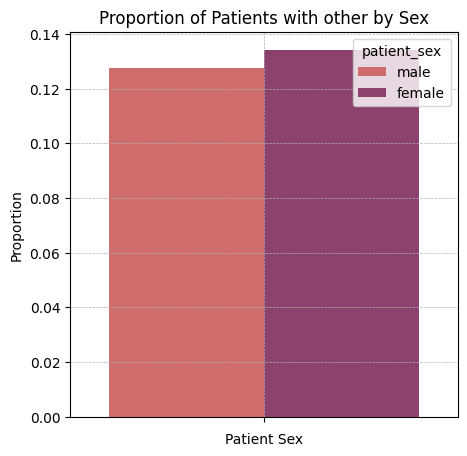

In [59]:
plot_age_by_pathology(new_odir_dataset, 'other')
plot_sex_by_pathology(new_odir_dataset, 'other')

In [60]:
new_odir_dataset = new_odir_dataset[new_odir_dataset['patient_age'] > 10]

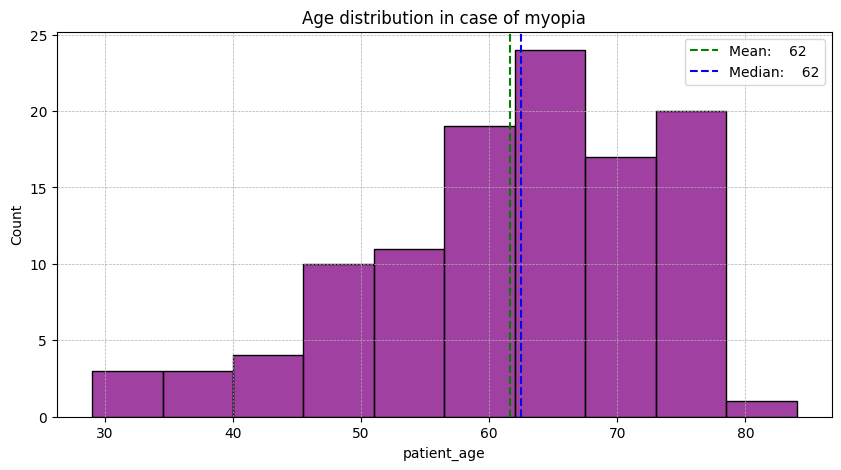

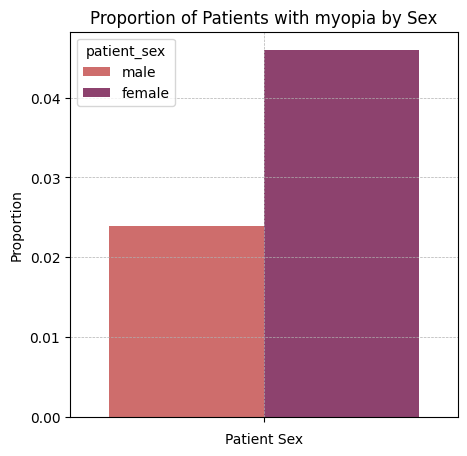

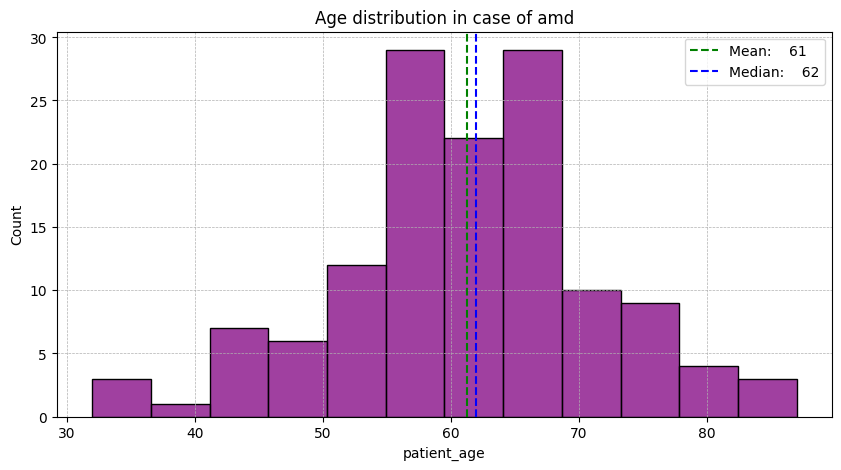

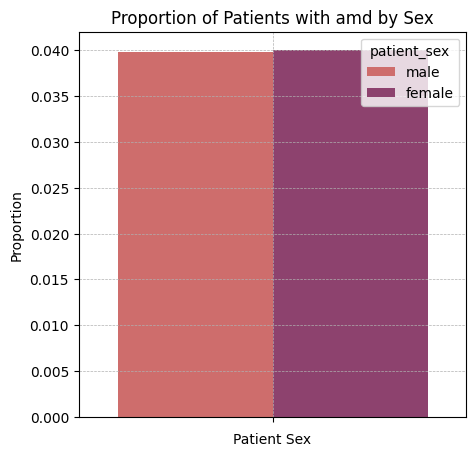

In [61]:
plot_age_by_pathology(new_odir_dataset, 'myopia')
plot_sex_by_pathology(new_odir_dataset, 'myopia')
plot_age_by_pathology(new_odir_dataset, 'amd')
plot_sex_by_pathology(new_odir_dataset, 'amd')

In [62]:
new_odir_dataset.head(3)

,patient_id,patient_age,patient_sex,fundus_image,exam_eye,normal_eye,diabetic_retinopathy,glaucoma,cataract,amd,hypertension,myopia,other
0,0,69,2,0_left.jpg,2,0,0,0,1,0,0,0,0
1,0,69,2,0_right.jpg,1,1,0,0,0,0,0,0,0
2,1,57,1,1_left.jpg,2,1,0,0,0,0,0,0,0


In [63]:
brset_data.head(3)

,image_id,patient_id,camera,patient_age,patient_sex,exam_eye,diabetes,nationality,optic_disc,vessels,...,amd,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality
0,img00001,1,Canon CR,48.0,1,1,1,Brazil,1,1,...,0,0,0,0,0,0,0,1,0,Adequate
1,img00002,1,Canon CR,48.0,1,2,1,Brazil,2,1,...,0,0,0,0,0,0,0,1,0,Adequate
2,img00003,2,Canon CR,18.0,2,1,1,Brazil,1,1,...,0,0,0,0,0,0,0,0,0,Adequate


In [64]:
brset_data.columns

Index(['image_id', 'patient_id', 'camera', 'patient_age', 'patient_sex',
       'exam_eye', 'diabetes', 'nationality', 'optic_disc', 'vessels',
       'macula', 'DR_SDRG', 'DR_ICDR', 'focus', 'Illuminaton', 'image_field',
       'artifacts', 'diabetic_retinopathy', 'macular_edema', 'scar', 'nevus',
       'amd', 'vascular_occlusion', 'hypertensive_retinopathy', 'drusens',
       'hemorrhage', 'retinal_detachment', 'myopic_fundus',
       'increased_cup_disc', 'other', 'quality'],
      dtype='object')

In [100]:
brset_data['normal_eye'] = pd.Series(np.where(brset_data[['DR_SDRG', 'DR_ICDR', 'diabetic_retinopathy', 
                                                          'macular_edema', 'scar', 'nevus',
                                                          'amd', 'vascular_occlusion', 'hypertensive_retinopathy', 'drusens',
                                                          'hemorrhage', 'retinal_detachment', 'myopic_fundus',
                                                          'increased_cup_disc', 'other']].eq(0).all(axis=1), 1, 0), brset_data.index)

In [101]:
new_odir_dataset.columns

Index(['patient_id', 'patient_age', 'patient_sex', 'fundus_image', 'exam_eye',
       'normal_eye', 'diabetic_retinopathy', 'glaucoma', 'cataract', 'amd',
       'hypertension', 'myopia', 'other'],
      dtype='object')

# Комбинирование датасетов

In [102]:
final_odir_dataset = new_odir_dataset.copy()
final_brset_dataset = brset_data.copy()

final_odir_dataset['data_source'] = 'ODIR'
final_brset_dataset['data_source'] = 'BRSET'

final_brset_dataset.drop(columns=['camera', 'nationality', 'diabetes', 'optic_disc', 'vessels',
                                                        'macula', 'DR_SDRG', 'DR_ICDR', 'focus', 'Illuminaton', 'image_field', 'artifacts',
                                                        'quality'], inplace=True)


final_odir_dataset = final_odir_dataset.rename(columns={'fundus_image': 'image_id'})
final_odir_dataset = final_odir_dataset.rename(columns={'hypertension': 'hypertensive_retinopathy'})
final_odir_dataset = final_odir_dataset.rename(columns={'myopia': 'myopic_fundus'})
final_odir_dataset['patient_id'] = final_odir_dataset['patient_id'] + 8524 + 1

combined_dataset = pd.concat([final_brset_dataset, final_odir_dataset], ignore_index=True)


display(combined_dataset)

,image_id,patient_id,patient_age,patient_sex,exam_eye,diabetic_retinopathy,macular_edema,scar,nevus,amd,...,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,normal_eye,data_source,glaucoma,cataract
0,img00001,1,48.0,1,1,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,1.0,0,0,BRSET,NaN,NaN
1,img00002,1,48.0,1,2,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,1.0,0,0,BRSET,NaN,NaN
2,img00003,2,18.0,2,1,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,1,BRSET,NaN,NaN
3,img00004,2,18.0,2,2,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,1,BRSET,NaN,NaN
4,img00005,3,22.0,1,1,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,1,BRSET,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820,4689_right.jpg,13214,54.0,1,1,0,NaN,NaN,NaN,0,...,NaN,NaN,NaN,0,NaN,0,1,ODIR,0.0,0.0
16821,4690_left.jpg,13215,57.0,1,2,1,NaN,NaN,NaN,0,...,NaN,NaN,NaN,0,NaN,0,0,ODIR,0.0,0.0
16822,4690_right.jpg,13215,57.0,1,1,1,NaN,NaN,NaN,0,...,NaN,NaN,NaN,0,NaN,0,0,ODIR,0.0,0.0
16823,4784_left.jpg,13309,58.0,1,2,0,NaN,NaN,NaN,1,...,NaN,NaN,NaN,0,NaN,0,0,ODIR,0.0,0.0


In [103]:
combined_dataset = combined_dataset.fillna(0)

In [104]:
combined_dataset

,image_id,patient_id,patient_age,patient_sex,exam_eye,diabetic_retinopathy,macular_edema,scar,nevus,amd,...,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,normal_eye,data_source,glaucoma,cataract
0,img00001,1,48.0,1,1,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,1.0,0,0,BRSET,0.0,0.0
1,img00002,1,48.0,1,2,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,1.0,0,0,BRSET,0.0,0.0
2,img00003,2,18.0,2,1,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,1,BRSET,0.0,0.0
3,img00004,2,18.0,2,2,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,1,BRSET,0.0,0.0
4,img00005,3,22.0,1,1,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,1,BRSET,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820,4689_right.jpg,13214,54.0,1,1,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,1,ODIR,0.0,0.0
16821,4690_left.jpg,13215,57.0,1,2,1,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0,ODIR,0.0,0.0
16822,4690_right.jpg,13215,57.0,1,1,1,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0.0,0,0,ODIR,0.0,0.0
16823,4784_left.jpg,13309,58.0,1,2,0,0.0,0.0,0.0,1,...,0.0,0.0,0.0,0,0.0,0,0,ODIR,0.0,0.0


In [105]:
diseases_to_convert_to_int = ['increased_cup_disc','macular_edema', 'scar', 'nevus', 'vascular_occlusion', 'drusens', 'hemorrhage', 'retinal_detachment', 'normal_eye', 'glaucoma', 'cataract']

combined_dataset[diseases_to_convert_to_int] = combined_dataset[diseases_to_convert_to_int].astype(int)


# Итоговый набор

In [106]:
combined_dataset

,image_id,patient_id,patient_age,patient_sex,exam_eye,diabetic_retinopathy,macular_edema,scar,nevus,amd,...,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,normal_eye,data_source,glaucoma,cataract
0,img00001,1,48.0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,BRSET,0,0
1,img00002,1,48.0,1,2,0,0,0,0,0,...,0,0,0,0,1,0,0,BRSET,0,0
2,img00003,2,18.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,1,BRSET,0,0
3,img00004,2,18.0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,1,BRSET,0,0
4,img00005,3,22.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,BRSET,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820,4689_right.jpg,13214,54.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,ODIR,0,0
16821,4690_left.jpg,13215,57.0,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0,ODIR,0,0
16822,4690_right.jpg,13215,57.0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,ODIR,0,0
16823,4784_left.jpg,13309,58.0,1,2,0,0,0,0,1,...,0,0,0,0,0,0,0,ODIR,0,0


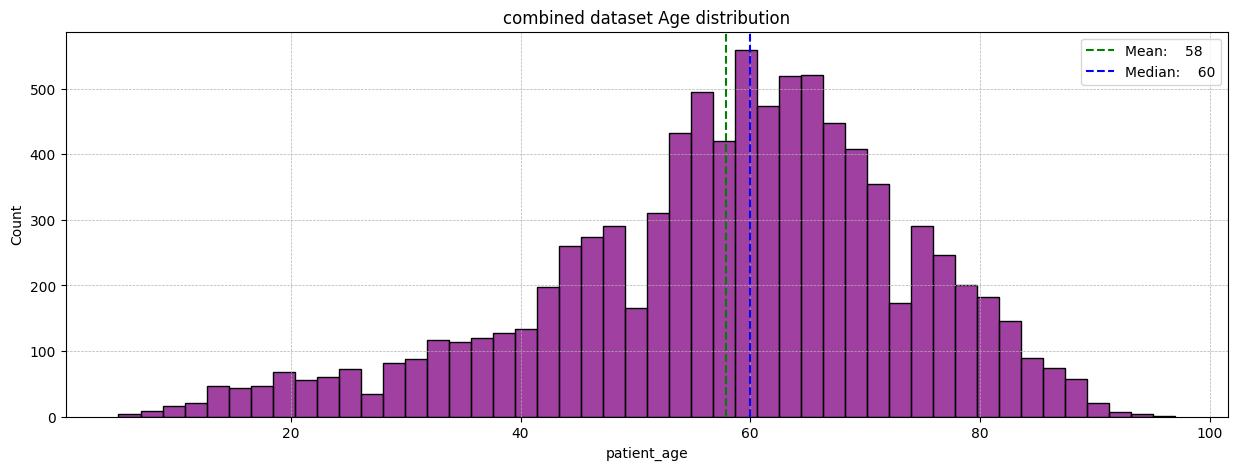

In [107]:
plt.figure(figsize=(15, 5))
combined_dataset_grouped_by_id = combined_dataset.groupby('patient_id').first().reset_index()
ax = sns.histplot(data = combined_dataset_grouped_by_id, x='patient_age', color='purple')

mean_age = np.nanmean(combined_dataset_grouped_by_id['patient_age'])
median_age = np.nanmedian(combined_dataset_grouped_by_id['patient_age'])
plt.axvline(x=mean_age, 
            linestyle = '--',
            label='Mean: {:5.0f}'.format(mean_age),
            color='green')
plt.axvline(x=median_age, 
            linestyle = '--',
            label='Median: {:5.0f}'.format(median_age),
            color='blue')
plt.grid(True, linestyle = '--', linewidth = 0.5)
plt.title("combined dataset Age distribution")
plt.legend(loc=0)
plt.show()

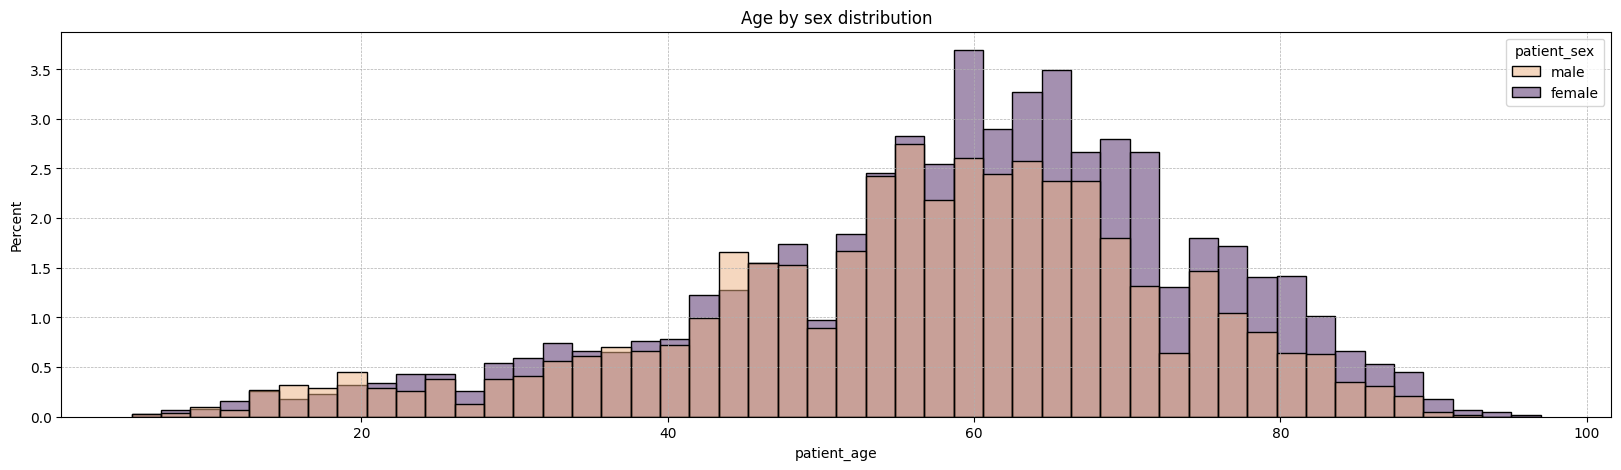

In [108]:
plt.figure(figsize=(20, 5))
labels = ['male', 'female']
ax = sns.histplot(data = combined_dataset_grouped_by_id, x='patient_age', stat='percent', hue='patient_sex', palette='flare')
plt.grid(True, linestyle = '--', linewidth = 0.5)
plt.title("Age by sex distribution")
for text, label in zip(ax.get_legend().texts, labels):
    text.set_text(label)

plt.show()

In [109]:
combined_dataset['image_id'] = combined_dataset['image_id'].apply(lambda x: f'{x}.jpg' if '.' not in x else x)

In [110]:
combined_dataset.to_csv('combined_dataset_ver1.csv', index=False) 